In [1]:
import Pkg; Pkg.activate("../"); # Activate the project 

  Activating project at `~/Documents/Research/MonitoringMetrology/QuTaM.jl`


# Driven Qubit
Following example A in Landi (2024)
The system of interest has hamiltonian:

$$ H = \frac{\Delta}{2} \sigma_z + \Omega \sigma_x$$

and jump operators

$$ L_1 = \gamma(\bar{N} +1 )\sigma_- $$
$$ L_2 = \gamma\bar{N}\sigma_- $$

For $\Omega=0$ the master equation has a steady state that's diagonal in the computational basis and $\langle\sigma_z\rangle = \frac{-1}{2\bar{N}+1}$

# Case $\Omega = 0$

In [2]:
using LinearAlgebra, QuTaM, Plots, LaTeXStrings, Statistics

Precompiling QuTaM
  ✓ QuTaM
  1 dependency successfully precompiled in 7 seconds. 249 already precompiled.


In [43]:
########################## INITIALIZATION
# Define the hamiltonian
delta = 1 # Constant following Landi figure 7
gamma = 1
omega = 0
nbar = 0.2
H = 0.5*delta * QuTaM.sigma_z + omega*QuTaM.sigma_x
# Define the jump operators
L1 = gamma*(nbar+1)*QuTaM.sigma_m
L2 = gamma*(nbar)*QuTaM.sigma_p
# Define the system
psi0 = zeros(ComplexF64, 2)
psi0[2] = 1
sys = System(H, [L1, L2])
params = SimulParameters(psi0,
    25.0, # Final time. Set very long so that all trajectories jump
    1, # seed
    2000, # Number of trajectories
    75_000, # Number of samples in the finegrid
    1.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)

SimulParameters(psi0=ComplexF64[0.0 + 0.0im, 1.0 + 0.0im]
nsamples=75000
seed=1
ntraj=2000)
multiplier=1.0
tf=25.0
dt=0.0003333333333333333
eps=0.001)

In [44]:
# Generate trajectories
sample_clicks = run_trajectories(sys, params);

Sampling... 100%|████████████████████████████████████████| Time: 0:03:13


In [45]:
# Obtain states between jumps
ntimes = 10000
t = collect(LinRange(0, params.tf, ntimes))
sample_states = zeros(ComplexF64, ntimes, sys.NLEVELS, params.ntraj)
for k in 1:params.ntraj
    states_k = evaluate_at_t(t, sample_clicks[k], sys, psi0)
    for j in 1:sys.NLEVELS 
        for tn in 1:ntimes 
            sample_states[tn, j, k] = states_k[tn, j]
        end 
    end 
end 

## Currents
The current we are interested in is

$$ J(t) = \gamma\bar{N}<\sigma_-\sigma_+> -  \gamma\bar{N}<\sigma_+\sigma_.> $$ 

in the steady state

$$ J_s(t) = -\frac{\gamma\Omega^2}{\Delta^2+2\Omega^2+ \gamma^2(\bar{N}+\frac{1}{2})^2} $$

In [46]:
# Evaluate the occupation number of the excited state
sample_occupation_e = zeros(Float64, ntimes,  params.ntraj)
sample_occupation_g = zeros(Float64, ntimes,  params.ntraj)
sample_sigma_z = zeros(Float64, ntimes,  params.ntraj)
number_e = QuTaM.sigma_p * QuTaM.sigma_m
number_g = QuTaM.sigma_m * QuTaM.sigma_p
for k in 1:params.ntraj
    for tn in 1:ntimes 
        sample_occupation_e[tn, k] = dot(sample_states[tn, :, k], number_e * sample_states[tn, :, k])
        sample_occupation_g[tn, k] = dot(sample_states[tn, :, k], number_g * sample_states[tn, :, k])
        sample_sigma_z[tn, k] = dot(sample_states[tn, :, k], QuTaM.sigma_z * sample_states[tn, :, k])
    end 
end 

In [47]:
#Analyzing a given trajectory 
traj_index = 3
waiting_times = [click.time for click in sample_clicks[traj_index]] 
jump_times = cumsum(waiting_times)
times = Array{Float64}
jump_indeces = []
jump_labels = []
counter = 1
# Find the indices of the jumps
for t_jump in jump_times
    while (t[counter] < t_jump) && (counter < size(t)[1])
        counter = counter + 1
    end  
    if counter == size(t)[1]
        break
    end 
    push!(jump_indeces, counter)
end 

In [48]:
# Evaluate the net charge
traj = sample_clicks[3]
weights = [-1.0, 1.0]
function get_charge(t_given::Vector{Float64}, traj::Trajectory, weights::Vector{Float64})
    ntimes = size(t_given)[1]
    charge = zeros(Float64, ntimes)
    # Edge case: if the trajectory had no jumps, it has zero charge
    if isempty(traj)
        return charge
    end 
    njumps = size(traj)[1]
    wait_times = [click.time for click in traj] 
    jump_times = cumsum(wait_times)
    charge_counter = 0
    j_counter = 1
    t_counter = 1
    # Current for times before the final jump
    while j_counter < njumps
        while t_given[t_counter] < jump_times[j_counter]
            charge[t_counter] = charge_counter
            t_counter = t_counter + 1
            if t_counter > ntimes # if there are no more times, return
                return charge
            end 
        end 
        charge_counter = charge_counter + weights[traj[j_counter].label]
        j_counter = j_counter + 1
    end 
    # After the final jump 
    charge[t_counter:end] .= charge_counter
    return charge
end 

get_charge (generic function with 1 method)

In [49]:
# Obtain the current
current_sample = zeros(Float64, ntimes, params.ntraj)
for k in 1:params.ntraj
    charge = get_charge(t, sample_clicks[k], weights)
    for tn in 2:ntimes
        current_sample[tn, k] = (charge[tn] -  charge[tn-1]) # WARNING: THIS IS NOT NORMALIZED 
    end 
end 

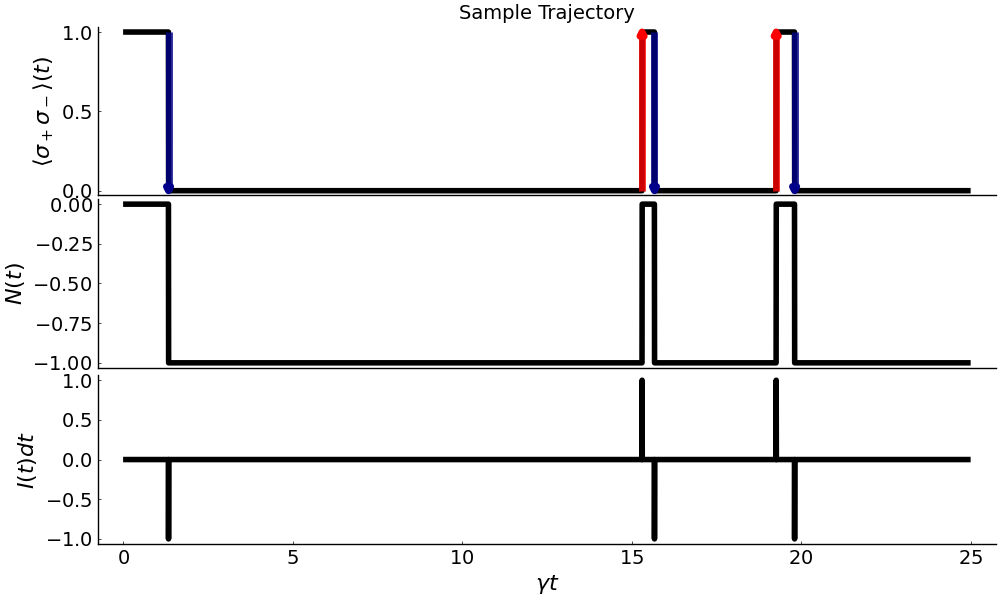

In [50]:
# Plot
pyplot()
charge_sample = get_charge(t, traj, weights)
p = plot(t, sample_occupation_e[:, traj_index], legend=false, linewidth=4, color="black",
             guidefont=font(16), grid=:false, gridalpha = 0.5, 
            ylabel = L"\langle\sigma_+\sigma_-\rangle(t)", title="Sample Trajectory", xticks=false,
            bottom_margin=0*Plots.mm, tickfont=font(14), yticks=[0.0, 0.5, 1.0])
# Add jump indicators
for j in jump_indeces
    if sample_occupation_e[j-1, traj_index] > sample_occupation_e[j+1, traj_index]
        plot!([t[j], t[j]], [sample_occupation_e[j-1, traj_index], sample_occupation_e[j+1, traj_index]],
              linewidth=5, alpha=0.8, color="darkblue", 
              arrow=:true, arrowsize=49)
    elseif sample_occupation_e[j-1, traj_index] < sample_occupation_e[j+0, traj_index]
        plot!([t[j], t[j]], [sample_occupation_e[j-1, traj_index], sample_occupation_e[j+1, traj_index]],
              linewidth=5, alpha=0.8, color="red", 
              arrow=:true, arrowsize=49)
    end 
end 
charge_plot = plot(t, charge_sample , color="black", linewidth=4, grid=:false, gridalpha = 0.5,
                    xticks=false, guidefont=(16), ylabel=L"N(t)", legend=:false)

current_plot = plot(t, current_sample[:, 3] , color="black", linewidth=4, grid=:false, gridalpha = 0.5,
                    xlabel=L"\gamma t", guidefont=(16), ylabel=L"I(t)dt", legend=:false)
plot(p, charge_plot ,current_plot, layout=(3,1), size=(1000, 600), tickfont=font(14))

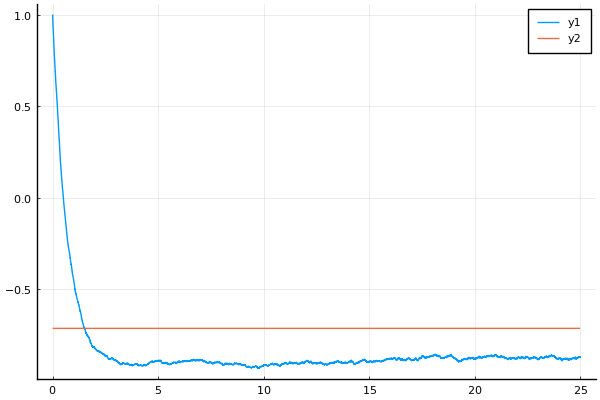

In [57]:
excited_population = dropdims(mean(sample_occupation_e, dims=2), dims=2)
ground_population = dropdims(mean(sample_occupation_g, dims=2), dims=2)
sz = dropdims(mean(sample_sigma_z, dims=2), dims=2)
average_current = gamma*nbar*ground_population - gamma*(nbar+1)*excited_population
plot(t, sz)
plot!(t, -1/(1+2*nbar)*ones(Float64, ntimes))

In [75]:
extrema(t)

(0.0, 25.0)